In [1]:
cd /Users/bryanprazen/Dropbox (Personal)/code/ds/project/good_churn/good_churn_project

/Users/bryanprazen/Dropbox (Personal)/code/ds/project/good_churn/good_churn_project


In [2]:
import getpass
import data_collection
import text_processing
import feature_building
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import collections
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import sklearn.metrics as skm

In [3]:
db = getpass.getpass()

········


In [4]:
db_user = getpass.getpass()

········


#Training and Testing Data Setup

In [10]:
cd /Users/bryanprazen/Dropbox (Personal)/code/ds/project

/Users/bryanprazen/Dropbox (Personal)/code/ds/project


In [11]:
good_churn_users = pd.read_csv('churn_users_14.csv')
bad_churn_users = pd.read_csv('bad_churn.csv')
test_users = pd.read_csv('test_users.csv')

In [12]:
good_churn_users['churn_date'] = pd.to_datetime(good_churn_users['churn_date'])
bad_churn_users['last_day'] = pd.to_datetime(bad_churn_users['last_day'])
test_users['last_day'] = pd.to_datetime(test_users['last_day'])

In [13]:
admin_users = [1,5,4] #user_ids of test and admin/tech support

In [14]:
good_churn_users_for_model = list(set(good_churn_users.user_id) - set(bad_churn_users.user_id)
                                  - set(test_users.user_id)- set(admin_users))
# remove admin users and users that also qualify under the bad churn criteria

In [15]:
good_churn_users = good_churn_users[good_churn_users['user_id'].isin(good_churn_users_for_model)]

In [16]:
'''Some users will qualify for th egood churn class with multiple events. 
This code will retain only the first qualifying event.
''' 
single_churn = pd.DataFrame(columns= ['user_id', 'churn_date', 'No_prechurn_activities', 'No_postchurn_activities'])
for user in good_churn_users_for_model:
    user_curns = good_churn_users[good_churn_users['user_id'] == user]
    #select = user_curns.sort(['No_prechurn_activities', 'churn_date'], ascending=False) # pre-churn activity
    select = user_curns.sort(['churn_date'], ascending=True) # first churn
    single_churn = single_churn.append(select[:1], ignore_index=True)
good_churn_users = single_churn

In [17]:
'''
Combination of Good Churn and Bad Churn users to create data set for training and validation
'''
gcu = good_churn_users[['user_id', 'churn_date']]
bcu = bad_churn_users[['user_id', 'last_day']]
bcu.columns = ['user_id', 'churn_date']
model_train_users_df = pd.concat([gcu, bcu])

In [18]:
# Number of days a data to include in the analysis time-window
pre_curn_monitoring_days = 14

In [20]:
'''
Creation of a time-window to use in analysis
'''
model_train_users_df['pre_churn_date'] = model_train_users_df['churn_date'] - pd.tslib.Timedelta(days=pre_curn_monitoring_days)

#Train/Test Split

In [21]:
# Run script that adds a class column to a dataframe
model_train_users_df = text_processing.add_class_to_df(model_train_users_df, good_churn_users_for_model)

In [22]:
y = model_train_users_df['class']
X = model_train_users_df[['user_id', 'churn_date', 'pre_churn_date']]

In [23]:
'''
Split the users into a training and testing (validation) set.  
Note that features are not joined with the users yet. This made development 
of text features on traing data more straight forward.
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=67)

#Text data feature engineering

In [25]:
'''
Optimization of the number of PC's determined through previous cross-validation 
and an assesment of the varriance in the PC's
'''
No_PCs = 15

In [26]:
training_text_matrix, vectorizer, svd = text_processing.train_text_clusters3(db, db_user, X_train, No_PCs)

#Application of text feature model to Test Data

In [27]:
testing_text_matrix = text_processing.test_text_clusters3(db, db_user, X_test, vectorizer, svd)

#Application of text feature model to unknown user data (users that resently left the app)

In [28]:
#preprocess 
test_users.columns = ['Unnamed: 0', 'user_id', 'churn_date', 'activity_count']
test_users['pre_churn_date'] = test_users['churn_date'] - pd.tslib.Timedelta(days=pre_curn_monitoring_days)

In [29]:
# Changed name to unknown to destinguish samples from group used to validate the model
unknown_text_matrix = text_processing.test_text_clusters3(db, db_user, test_users, vectorizer, svd)

# Build numeric features and join class data

In [30]:
training_nf_matrix = feature_building.feature_df_maker2(db, db_user, X_train)
training_nf_matrix = text_processing.add_class_to_df(training_nf_matrix, good_churn_users_for_model)

In [31]:
test_nf_matrix = feature_building.feature_df_maker2(db, db_user, X_test)
test_nf_matrix = text_processing.add_class_to_df(test_nf_matrix, good_churn_users_for_model)

In [32]:
unknown_nf_matrix = feature_building.feature_df_maker2(db, db_user, test_users)

#Join Text and Numeric Features

In [33]:
training_text_matrix = training_text_matrix.set_index('user_id')
training_nf_matrix = training_nf_matrix.set_index('user_id')
testing_text_matrix = testing_text_matrix.set_index('user_id')
test_nf_matrix = test_nf_matrix.set_index('user_id')
unknown_text_matrix = unknown_text_matrix.set_index('user_id')
unknown_nf_matrix = unknown_nf_matrix.set_index('user_id')

In [34]:
training_matrix = training_nf_matrix.join(training_text_matrix)
training_matrix = training_matrix.fillna(0)
test_matrix = test_nf_matrix.join(testing_text_matrix)
test_matrix = test_matrix.fillna(0)
unknown_matrix = unknown_nf_matrix.join(unknown_text_matrix)
unknown_matrix = unknown_matrix.fillna(0)

#Train and Test Model

In [35]:
y_train = training_matrix['class']
X_train = training_matrix.drop(['class'],1)
y_test = test_matrix['class']
X_test = test_matrix.drop(['class'],1)

In [36]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced')
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)
pred_prob = rfc.predict_proba(X_test)
roc_auc_score(y_test, pred_prob[:,1])

0.86989083523736976

In [37]:
cd /Users/bryanprazen/Dropbox (Personal)/code/ds/project/good_churn/good_churn_project

/Users/bryanprazen/Dropbox (Personal)/code/ds/project/good_churn/good_churn_project


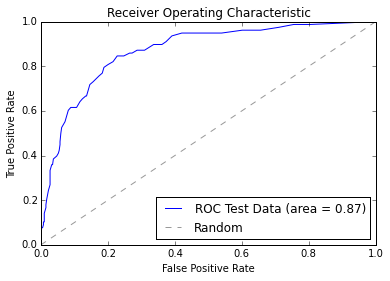

In [38]:
fp_rate, tp_rate, thresholds = skm.roc_curve(y_test, pred_prob[:,1])
plt.plot(fp_rate, tp_rate, label='ROC Test Data (area = 0.87)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.legend(loc="lower right")
#plt.savefig('../images/roc4.png')

In [40]:
cd /Users/bryanprazen/Dropbox (Personal)/code/ds/w4d3/random-forest/code

/Users/bryanprazen/Dropbox (Personal)/code/ds/w4d3/random-forest/code


In [41]:
import roc

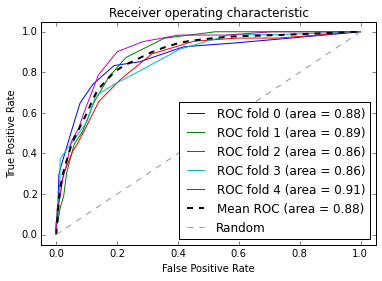

In [42]:
roc.plot_roc(X_train, y_train.values, RandomForestClassifier, n_estimators=20)

In [43]:
sum(pred == y_test)/float(len(pred))

0.86721991701244816

In [44]:
def plot_confusion_matrix(model, X_test, y_true):
    '''Code stolen brazenly from sklearn example.'''
    cm = confusion_matrix(y_true, model.predict(X_test))

    print(cm)

    # Show confusion matrix in a separate window
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[[393  11]
 [ 53  25]]


//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


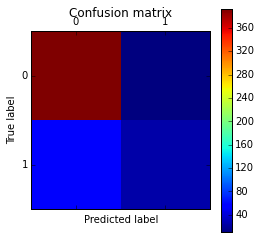

In [45]:
plot_confusion_matrix(rfc, X_test, y_test)

In [46]:
def plot_importance(clf, X, max_features=10):
    '''
    Plot feature importance. 
    Code from lectures.
    '''
    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    # Show only top features
    pos = pos[-max_features:]
    feature_importance = (feature_importance[sorted_idx])[-max_features:]
    feature_names = (X.columns[sorted_idx])[-max_features:]
    
    plt.barh(pos, feature_importance, align='center')
    plt.yticks(pos, feature_names)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')

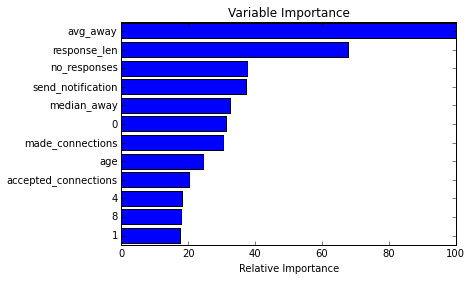

In [47]:
plot_importance(rfc, X_test, max_features=12)

#Process and Classify Unknown Samples

In [48]:
pred_unknown = rfc.predict(unknown_matrix)
sum(pred_unknown)/len(pred_unknown)

0.053956834532374098

In [49]:
pred_proba_unknown = rfc.predict_proba(unknown_matrix)
sum(pred_proba_unknown[:,1]>0.22)
# threshold at ~ 0.8 TPR 

60